> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/SearchDownload_SWOTviaCMR.ipynb).

Altered version by Ben Kraas
Original version by Cassandra Nickles, PO.DAAC

# Search and Download SWOT Data via `earthaccess`

## Summary
This notebook will find and download pre-validated SWOT hydrology data (v2.0) programmatically via earthaccess python library. For more information about earthaccess visit: https://nsidc.github.io/earthaccess/

## Requirements
### 1. Compute environment 
This tutorial can be run in the following environments:
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

In [31]:
import geopandas as gpd
import glob
from pathlib import Path
import pandas as pd
import os
import zipfile
import earthaccess
import contextily as ctx

In [42]:
# setup:
data_dir = Path('data')
lake_vector_shapefile_dir = data_dir / 'lake_vector_shapefiles'
water_mask_pixel_cloud_dir = data_dir / 'water_mask_pixel_cloud'

In this notebook, we will be calling the authentication in the below cell.

In [3]:
auth = earthaccess.login() 

### Search for SWOT data links
We want to find the SWOT files for a particular pass over North America. 

Each dataset has it's own unique shortname, which can be used to search earthaccess. Shortnames can be found on dataset landing pages or [Earthdata Search](https://search.earthdata.nasa.gov/search) Collections.

#### SWOT Level 2 KaRIn High Rate Version 2.0 Datasets:

- **Water Mask Pixel Cloud NetCDF** - SWOT_L2_HR_PIXC_2.0
- **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0
- **River Vector Shapefile** - SWOT_L2_HR_RiverSP_2.0
- **Lake Vector Shapefile** - SWOT_L2_HR_LakeSP_2.0
- **Raster NetCDF** - SWOT_L2_HR_Raster_2.0

Let's start our search for River Vector Shapefiles with a particular pass, pass 013. SWOT files come in "reach" and "node" versions in the same collection, here we want the 10km reaches rather than the nodes. We will also only get files for North America, or 'NA' and call out a specific pass number that we want.

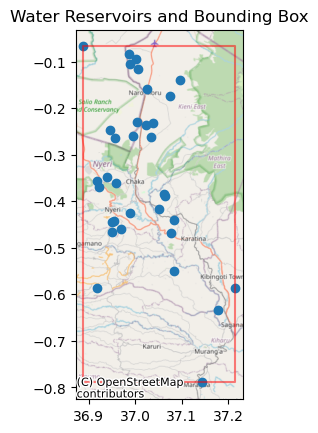

In [40]:
water_reservoirs = gpd.read_file(data_dir) 	# open the shapefile data/Reservoirs.shp
water_reservoirs = water_reservoirs.to_crs(epsg=4326) 		# Set the CRS to WGS84 (lat/lon)
bbox = water_reservoirs.geometry.union_all().bounds 		# get the outer bounds of all reservoirs combined
bbox_gdf = gpd.GeoDataFrame(geometry=[water_reservoirs.geometry.union_all().envelope]) 	# create a GeoDataFrame with the bounding box

# plot both the reservoirs and the bounding box at the same time
ax = water_reservoirs.plot()
bbox_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)
# add a base map
ctx.add_basemap(ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326')
ax.set_title('Water Reservoirs and Bounding Box')
ax.set_aspect('equal')
ax.figure.savefig(data_dir / 'reservoirs_and_bbox.png')
ax.figure.show()

In [43]:
# search for SWOT data in the bounding box region and download it to the datasets directory
# first, we search for the vector data

# if the directory exists and there are files in it, skip the download
if lake_vector_shapefile_dir.exists() and len(list(lake_vector_shapefile_dir.glob('*.zip'))) > 0:
    print(f"Found {len(list(lake_vector_shapefile_dir.glob('*.zip')))} existing vector files in {lake_vector_shapefile_dir}. Skipping download.")
else:
    results = earthaccess.search_data(short_name = 'SWOT_L2_HR_LakeSP_2.0', 
                                    temporal = ('2024-02-01 00:00:00', '2024-02-20 23:59:59'), # can also specify by time
                                    bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3])) # lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat
    print(f"Found {len(results)} vector files in the region. Downloading...")
    earthaccess.download(results, lake_vector_shapefile_dir)

# secondly, we search for the pixel cloud data
if water_mask_pixel_cloud_dir.exists() and len(list(water_mask_pixel_cloud_dir.glob('*.zip'))) > 0:
    print(f"Found {len(list(water_mask_pixel_cloud_dir.glob('*.zip')))} existing pixel cloud files in {water_mask_pixel_cloud_dir}. Skipping download.")
else:
    results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                    temporal = ('2024-02-01 00:00:00', '2024-02-20 23:59:59'), # can also specify by time
                                    bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3]))
    print(f"Found {len(results)} pixel cloud files in the region.")
    earthaccess.download(results, water_mask_pixel_cloud_dir)

Found 30 vector files in the region. Downloading...


QUEUEING TASKS | : 100%|██████████| 30/30 [00:00<00:00, 3533.43it/s]
PROCESSING TASKS | : 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]
COLLECTING RESULTS | : 100%|██████████| 30/30 [00:00<00:00, 236077.15it/s]


Found 7 pixel cloud files in the region.


In [ ]:
# download the data if it doesn't exist yet. 

During the science orbit, a pass will be repeated once every 21 days. A particular location may have different passes observe it within the 21 days, however.

### Download the Data into a folder

In [ ]:
earthaccess.download(results, "./datasets/data_downloads/SWOT_files/")
folder = Path("./datasets/data_downloads/SWOT_files")

### Shapefiles come in a .zip format, and need to be unzipped in the existing folder

In [8]:
for item in os.listdir(folder): # loop through items in dir
    if item.endswith(".zip"): # check for ".zip" extension
        zip_ref = zipfile.ZipFile(f"{folder}/{item}") # create zipfile object
        zip_ref.extractall(folder) # extract file to dir
        zip_ref.close() # close file

In [ ]:
os.listdir(folder)